In [1]:
import xupy as xp
from numpy.ma import masked_array
import matplotlib.pyplot as plt 

from ekarus.e2e.cascading_stage_ao_class import CascadingAO
from ekarus.e2e.utils import my_fits_package as myfits
from ekarus.e2e.utils.image_utils import reshape_on_mask

import os.path as op


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
cascao = CascadingAO(tn='cascading_8m')

def plot_masked_array(ma, id=None, mask=None):
    if mask is not None:
        img = reshape_on_mask(ma[id],mask)
        marray = masked_array(xp.asnumpy(img), xp.asnumpy(mask))
    else:
        ma_id = ma.copy()
        if id is not None:
            ma_id = ma[id]
        marray = masked_array(ma_id.data,mask=ma_id.mask)
    plt.imshow(marray,origin='lower',cmap='RdBu')
    plt.colorbar()
    plt.axis('off')

In [3]:
prf = ''
ma_atmo_phases, _, res1_phases, det1_frames, rec1_modes, dm1_cmds, _, res2_phases, det2_frames, rec2_modes, dm2_cmds = cascao.load_telemetry_data(save_prefix=prf)

In [4]:
KL = myfits.read_fits(op.join(cascao.savecalibpath,'DM1_KLmodes.fits'))
# KL2 = myfits.read_fits(op.join(cascao.savecalibpath,'DM2_KLmodes.fits'))
# phase2modes = xp.linalg.pinv(KL.T)

# def get_modes(ma,id):
#     im_data = ma[id].data
#     phase = xp.array(im_data[~ma[id].mask])
#     ph_rms = xp.sqrt(xp.sum(phase**2)/len(phase))
#     modes = phase2modes @ phase
#     rec_phase = KL.T @ modes
#     rec_phase_2d = reshape_on_mask(rec_phase, xp.asarray(ma[id].mask))
#     rec_ma = masked_array(xp.asnumpy(rec_phase_2d), ma[id].mask)
#     return modes, rec_ma, ph_rms

In [5]:
# atmo_modes, rec_atmo, atmo_rms = get_modes(ma_atmo_phases,-1)
# res1_modes, rec_ph1, res1_rms = get_modes(res1_phases,-1)
# res2_modes, rec_ph2, res2_rms = get_modes(res2_phases,-1)

# print(xp.sum(xp.abs(atmo_modes)),xp.sum(xp.abs(res1_modes)),xp.sum(xp.abs(res2_modes)))
# print(xp.sum(xp.abs(atmo_modes)*xp.std(KL.T,axis=0)),xp.sum(xp.abs(res1_modes)*xp.std(KL.T,axis=0)),xp.sum(xp.abs(res2_modes)*xp.std(KL.T,axis=0)))
# print(atmo_rms, res1_rms, res2_rms)

In [6]:
# mask = cascao.cmask.copy()
# # m2c1 = myfits.read_fits(op.join(cascao.savecalibpath,'DM1_m2c.fits'))
# # m2c2 = myfits.read_fits(op.join(cascao.savecalibpath,'DM2_m2c.fits'))

# # c2m1 = xp.linalg.pinv(m2c1[:rec1_modes.shape[1],:])
# # c2m2 = xp.linalg.pinv(m2c2[:rec2_modes.shape[1],:])

# # rec1_kls = c2m1 @ rec1_modes[-1]
# rec1_phase = KL[:rec1_modes.shape[1],:].T @ rec1_modes[-1]
# rec1_phase_2d = reshape_on_mask(rec1_phase, mask)
# rec1_ma = masked_array(xp.asnumpy(rec1_phase_2d), xp.asnumpy(mask))
# # rec2_kls = c2m2 @ rec2_modes[-1]
# rec2_phase = KL2[:rec2_modes.shape[1],:].T @ rec2_modes[-1]
# rec2_phase_2d = reshape_on_mask(rec2_phase, mask)
# rec2_ma = masked_array(xp.asnumpy(rec2_phase_2d), xp.asnumpy(mask))

In [7]:
# plt.figure(figsize=(16,12))
# plt.subplot(3,3,1)
# plot_masked_array(ma_atmo_phases,-1)
# plt.subplot(3,3,2)
# plot_masked_array(res1_phases,-1)
# plt.subplot(3,3,3)
# plot_masked_array(res2_phases,-1)
# plt.subplot(3,3,4)
# plot_masked_array(rec_atmo)
# plt.subplot(3,3,5)
# plot_masked_array(rec_ph1)
# plt.subplot(3,3,6)
# plot_masked_array(rec_ph2)
# plt.subplot(3,3,8)
# plot_masked_array(rec1_ma)
# plt.subplot(3,3,9)
# plot_masked_array(rec2_ma)

In [8]:
def filter_modes(atmo_phases, KL, nModes2Filter):
    MM = KL[:nModes2Filter,:]
    phase2modes = xp.linalg.pinv(MM.T)
    modes = phase2modes @ atmo_phases.T
    rec_phases = MM.T @ modes
    filt_phases = atmo_phases.T - rec_phases
    return filt_phases.T

def masked_array_to_matrix(ma_vec, mask):
    N = xp.shape(ma_vec)[0]
    data_len = int(xp.sum(1-mask))
    mat = xp.zeros([N,data_len])
    for i in range(N):
        mat[i,:] = xp.asarray(ma_vec[i].data)[~mask]
    return mat

In [9]:

atmo_phases = masked_array_to_matrix(ma_atmo_phases, cascao.cmask)
atmo_noTT_phases = filter_modes(atmo_phases, KL, 2)
filt10_phases = filter_modes(atmo_phases, KL, 10)
filt100_phases = filter_modes(atmo_phases, KL, 100)
filt200_phases = filter_modes(atmo_phases, KL, 200)
filt800_phases = filter_modes(atmo_phases, KL, 800)

In [10]:
lambdaRef = 750e-9
N = 128

atmo_phases_in_rad = atmo_phases[-N:,:] * (2*xp.pi)/lambdaRef
# filt5_phases_in_rad = filt5_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt10_phases_in_rad = filt10_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt100_phases_in_rad = filt100_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt200_phases_in_rad = filt200_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt800_phases_in_rad = filt800_phases[-N:,:] * (2*xp.pi)/lambdaRef

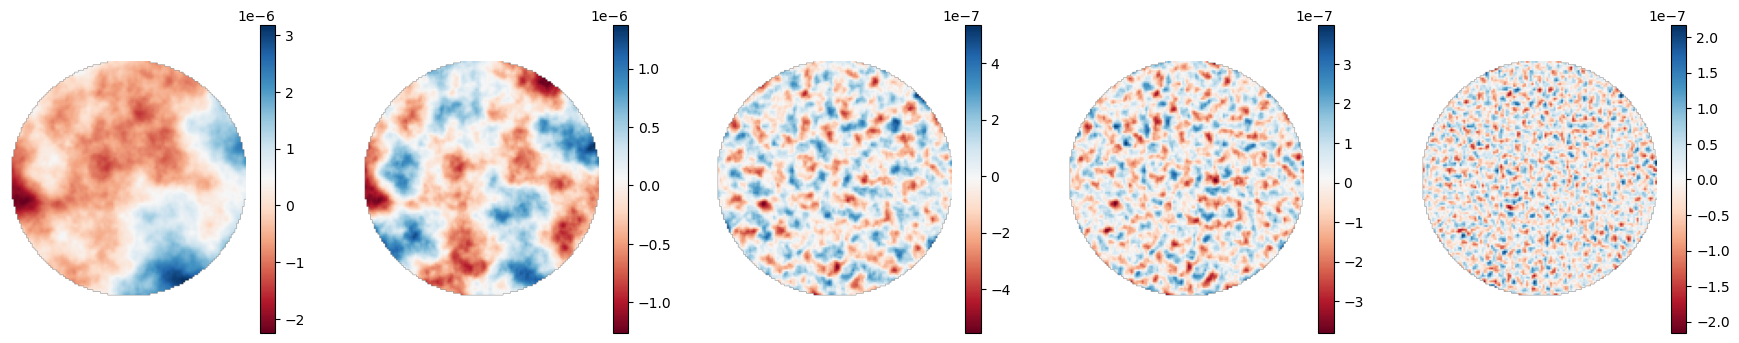

In [11]:
plt.figure(figsize=(22,4))
plt.subplot(1,5,1)
plot_masked_array(atmo_phases,-1, cascao.cmask)
plt.subplot(1,5,2)
plot_masked_array(filt10_phases,-1, cascao.cmask)
plt.subplot(1,5,3)
plot_masked_array(filt100_phases,-1, cascao.cmask)
plt.subplot(1,5,4)
plot_masked_array(filt200_phases,-1, cascao.cmask)
plt.subplot(1,5,5)
plot_masked_array(filt800_phases,-1, cascao.cmask)

In [12]:
normalize_to_perfect_psf = True
use_avg_field = False

_, rad_profile, pix_dist = cascao.get_contrast(atmo_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile10, pix_dist = cascao.get_contrast(filt10_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile100, pix_dist = cascao.get_contrast(filt100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile200, pix_dist = cascao.get_contrast(filt200_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile800, pix_dist = cascao.get_contrast(filt800_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)

Text(0.5, 1.0, 'Contrast with perfect coronograph\nand perfect correction')

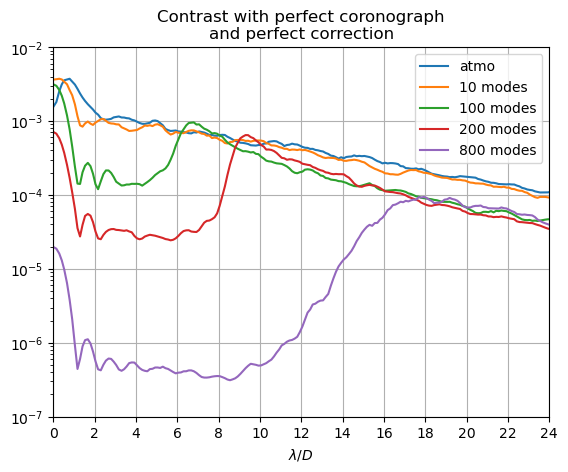

In [13]:
plt.figure()#figsize=(16,5))
# plt.subplot(1,2,1)
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile), label='atmo')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile5), label='5 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile10), label='10 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile100), label='100 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile200), label='200 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile800), label='800 modes')
plt.legend()
plt.grid()
plt.xlim([0,24])
plt.ylim([1e-7,1e-2])
plt.xticks(xp.asnumpy(xp.arange(0,26,2)))
plt.xlabel(r'$\lambda/D$')
plt.yscale('log')
plt.title('Contrast with perfect coronograph\nand perfect correction')

In [14]:
normalize_to_perfect_psf = True
use_avg_field = True

_, rad_profile, pix_dist = cascao.get_contrast(atmo_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile10, pix_dist = cascao.get_contrast(filt10_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile100, pix_dist = cascao.get_contrast(filt100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile200, pix_dist = cascao.get_contrast(filt200_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile800, pix_dist = cascao.get_contrast(filt800_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)

Text(0.5, 1.0, 'Contrast with perfect coronograph\nand perfect correction')

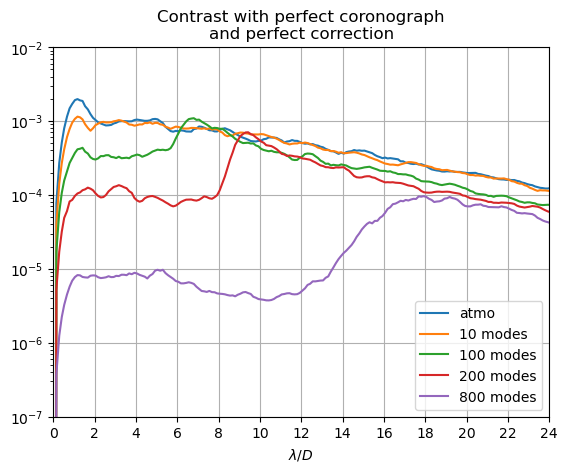

In [15]:
plt.figure()#figsize=(16,5))
# plt.subplot(1,2,1)
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile), label='atmo')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile5), label='5 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile10), label='10 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile100), label='100 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile200), label='200 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile800), label='800 modes')
plt.legend()
plt.grid()
plt.xlim([0,24])
plt.ylim([1e-7,1e-2])
plt.xticks(xp.asnumpy(xp.arange(0,26,2)))
plt.xlabel(r'$\lambda/D$')
plt.yscale('log')
plt.title('Contrast with perfect coronograph\nand perfect correction')

In [16]:
from ekarus.e2e.utils.image_utils import get_circular_mask
from arte.utils.radial_profile import computeRadialProfile

def lyot_coronograph(focal_field, occulter_radius, lyot_stop, oversampling):

    focal_mask = get_circular_mask(focal_field.shape,mask_radius=occulter_radius*oversampling)
    lyot_stop = 1-get_circular_mask(focal_field.shape,mask_radius=lyot_stop*max(focal_field.shape))
    field_after_stop = focal_field * focal_mask
    pupil = xp.fft.ifft2(xp.fft.ifftshift(field_after_stop))
    lyot_pupil = pupil * lyot_stop
    coro_focal_field = xp.fft.fftshift(xp.fft.fft2(lyot_pupil))
    psf = xp.abs(coro_focal_field)**2
    return psf

In [17]:
# perfect_amp = (1-cascao.cmask)
# oversampling = 8
# padded_field = xp.pad(perfect_amp, int((oversampling-1)/2*max(xp.shape(perfect_amp))), mode='constant', constant_values=0.0)
# perfect_ff = xp.fft.fftshift(xp.fft.fft2(padded_field))
# perfect_psf = xp.abs(perfect_ff)**2
# coro_psf = lyot_coronograph(perfect_ff, occulter_radius=3.0, lyot_stop=0.99, oversampling=oversampling)

# max_psf = xp.max(perfect_psf)
# perfect_psf /= max_psf
# coro_psf /= max_psf

# airy_profile,dist = computeRadialProfile(xp.asnumpy(perfect_psf),perfect_psf.shape[0]/2,perfect_psf.shape[1]/2)
# coro_profile,dist = computeRadialProfile(xp.asnumpy(coro_psf),perfect_psf.shape[0]/2,perfect_psf.shape[1]/2)
# pix_dist = dist/oversampling

# plt.figure()
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(airy_profile), label='airy')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(coro_profile), label='lyot')
# plt.legend()
# plt.grid()
# plt.xlim([0,20])
# plt.ylim([1e-16,1])
# plt.xticks(xp.asnumpy(xp.arange(0,22,2)))
# plt.xlabel(r'$\lambda/D$')
# plt.yscale('log')

In [18]:
def get_coro_psfs(res_phase, lambdaInM, occulter_radius, oversampling):

    res_phase_rad = res_phase * 2*xp.pi/lambdaInM

    pup_mask = xp.pad(cascao.cmask, int((oversampling-1)/2*max(xp.shape(cascao.cmask))), mode='constant', constant_values=1.0)
    field_amp = 1-pup_mask
    phase_2d = reshape_on_mask(res_phase_rad, pup_mask)

    input_field = field_amp * xp.exp(1j*phase_2d, dtype=xp.complex64)
    focal_field = xp.fft.fftshift(xp.fft.fft2(input_field))
    psf = xp.abs(focal_field)**2

    # phase_var = xp.sum((res_phase_rad-xp.mean(res_phase_rad))**2) 
    phase_var = reshape_on_mask((res_phase_rad-xp.mean(res_phase_rad))**2, pup_mask)
    perfect_coro_field = field_amp * (xp.sqrt(xp.exp(-phase_var))-xp.exp(1j*phase_2d))
    coro_focal_plane_ef = xp.fft.fftshift(xp.fft.fft2(perfect_coro_field))
    perfect_coro_psf = xp.abs(coro_focal_plane_ef)**2

    avg_electric_field = xp.sum(input_field * field_amp) / xp.sum(field_amp)
    electric_field_corrected = input_field - avg_electric_field * field_amp
    focal_field = xp.fft.fftshift(xp.fft.fft2(electric_field_corrected))
    lyot_coro_psf = xp.abs(focal_field)**2
    # lyot_coro_psf = lyot_coronograph(focal_field, occulter_radius, lyot_stop=0.98, oversampling=oversampling)

    max_psf = xp.max(psf)
    psf /= max_psf
    perfect_coro_psf /= max_psf
    lyot_coro_psf /= max_psf

    psf_profile,dist = computeRadialProfile(xp.asnumpy(psf),psf.shape[0]/2,psf.shape[1]/2)
    coro_profile,dist = computeRadialProfile(xp.asnumpy(perfect_coro_psf),psf.shape[0]/2,psf.shape[1]/2)
    lyot_profile,dist = computeRadialProfile(xp.asnumpy(lyot_coro_psf),psf.shape[0]/2,psf.shape[1]/2)
    pix_dist = dist/oversampling

    plt.figure()
    plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(psf_profile), label='psf')
    plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(coro_profile), label='perfect coro')
    plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(lyot_profile), label='specula perfect coro')
    # # plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(lyot_profile), label='lyot coro')
    plt.legend()
    plt.grid()
    plt.ylim([1e-16,1])
    plt.xlim([0,15])
    plt.xticks(xp.asnumpy(xp.arange(0,16)))
    plt.xlabel(r'$\lambda/D$')
    plt.yscale('log')

    return psf_profile, coro_profile, lyot_profile, pix_dist

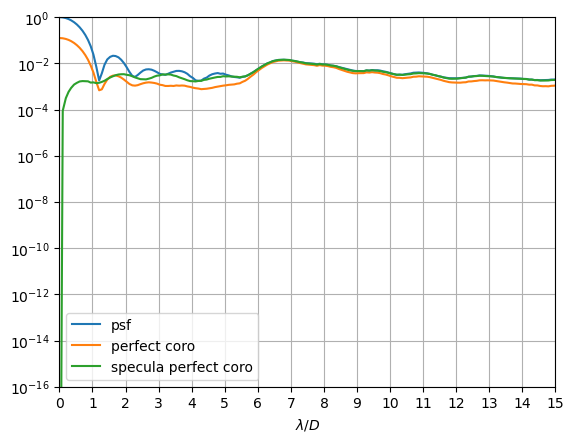

In [19]:
oversampling = 12
lambdaInM = 750e-9
occulter_radius = 3

id = -10

res_phase = filt100_phases[id,:]
psf_profile, coro_profile, lyot_profile, pix_dist = get_coro_psfs(res_phase, lambdaInM=lambdaInM, occulter_radius=occulter_radius, oversampling=oversampling)